In [1]:
import pandas as pd
import numpy as np

# DATA_PATH = '/home/sean/Documents/KITTI/2011_09_26_drive_0005_sync'

# 計算距離的部份, 短時間IMU更精準, 長時間GPS更準, 因為IMU會隨時間累進誤差

IMU_COLUMN_NAMES  = [ 'lat' , 'lon' , 'alt' , 'roll' , 'pitch' , 'yaw' , 'vn' , 've' , 'vf' , 'vl' , 'vu' , 'ax' , 'ay' , 'az' , 'af' ,
                    'al' , 'au' , 'wx' , 'wy' , 'wz' , 'wf' , 'wl' , 'wu' , 'posacc' , 'velacc' , 'navstat' , 'numsats' , 'posmode ' ,
                    'velmode' , 'orimode' ]

def read_imu(path):
    df = pd.read_csv(path, header=None, sep=' ')
    df.columns = IMU_COLUMN_NAMES
    return df 

def compute_great_circle_distance(lat1, lon1, lat2, lon2):
    """
    compute the great circle distance from two gps data
    Input : latitudes and longitudes in degree
    Output: distance in meter
    """
    # 餘弦球面定律公式 spherical law of cosines 計算兩經緯度點的球表面距離 (大圓距離計算)
    delta_sigma = float(np.sin(lat1*np.pi/180)*np.sin(lat2*np.pi/180) + \
                        np.cos(lat1*np.pi/180)*np.cos(lat2*np.pi/180)*np.cos(lon1*np.pi/180-lon2*np.pi/180))
    # 乘以 6371000 是為了將角距(單位：弧度)轉換為地球表面上兩點之間的實際距離(單位：米),6371000 代表地球的平均半徑。
    return 6371000.0 * np.arccos(np.clip(delta_sigma, -1, 1))

In [2]:
# 初始化
prev_imu_data = None
gps_distances = [] # 儲存到list
imu_distances = []

for frame in range(150):
    imu_data = read_imu('/home/sean/Documents/KITTI/2011_09_26_drive_0005_sync/oxts/data/%010d.txt'%frame)
    
    if prev_imu_data is not None:
        # 注意 這裡也是個list
        gps_distances += [compute_great_circle_distance(imu_data.lat, imu_data.lon, prev_imu_data.lat, prev_imu_data.lon)]
        #gps_distances.append(compute_great_circle_distance(imu_data.lat, imu_data.lon, prev_imu_data.lat, prev_imu_data.lon))
        # 這裡的 0.1是因為幀數的關係
        imu_distances += [0.1 * np.linalg.norm(imu_data[['vf', 'vl']])] # norm compute distance
        
    prev_imu_data = imu_data

In [3]:
# gps_distances
# imu_distances

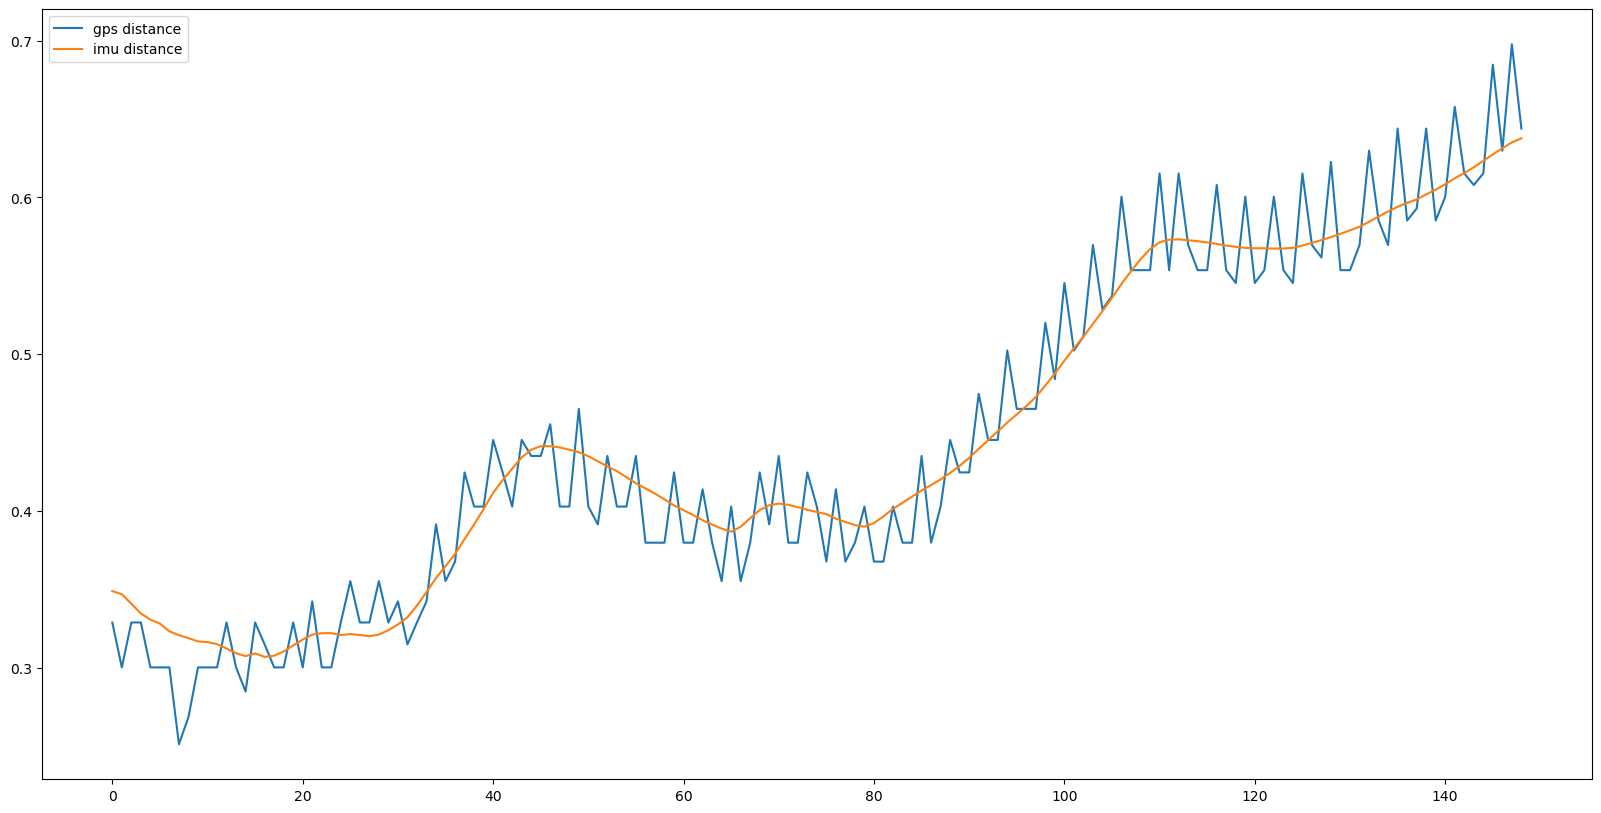

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize =(20, 10))
plt.plot(gps_distances, label= 'gps distance')
plt.plot(imu_distances, label= 'imu distance')
plt.legend()
plt.show()

In [5]:
read_imu('/home/sean/Documents/KITTI/2011_09_26_drive_0005_sync/oxts/data/0000000000.txt')

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,wf,wl,wu,posacc,velacc,navstat,numsats,posmode,velmode,orimode
0,49.011213,8.422885,112.834923,0.022447,0.00001,-1.22191,-3.325632,1.138431,3.514768,0.037625,...,-0.017499,0.021393,0.14563,0.492294,0.068884,4,10,4,4,0


In [6]:
read_imu('/home/sean/Documents/KITTI/2011_09_26_drive_0005_sync/oxts/data/0000000001.txt')

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,wf,wl,wu,posacc,velacc,navstat,numsats,posmode,velmode,orimode
0,49.01121,8.422887,112.846901,0.022857,0.004342,-1.206077,-3.288107,1.166745,3.488639,0.054704,...,-0.004166,0.044282,0.139954,0.492294,0.068884,4,10,4,4,0


In [9]:
# 初始化
prev_imu_data = None
locations = []

for frame in range(150):
    imu_data = read_imu('/home/sean/Documents/KITTI/2011_09_26_drive_0005_sync/oxts/data/%010d.txt'%frame)
    
    # 目前的imu_data與第零幀的imu_data做轉換
    if prev_imu_data is not None:
        # 注意 這裡也是個list
        # 這裡的 0.1是因為幀數的關係
        displacement = 0.1 * np.linalg.norm(imu_data[['vf', 'vl']])
        yaw_change = float(imu_data.yaw - prev_imu_data.yaw)
        for i in range(len(locations)):
            x0, y0 = locations[i]
            x1 = x0 * np.cos(yaw_change) + y0 * np.sin(yaw_change) - displacement # x1 是新的x座標
            y1 = -x0 * np.sin(yaw_change) + y0 * np.cos(yaw_change)
            locations[i] = np.array([x1, y1])
            
    locations += [np.array([0, 0])] # 第一幀永遠是(0, 0) 並且因為是自己的車，所以後面要加上的每一幀都是(0, 0)
    prev_imu_data = imu_data

In [17]:
# locations 

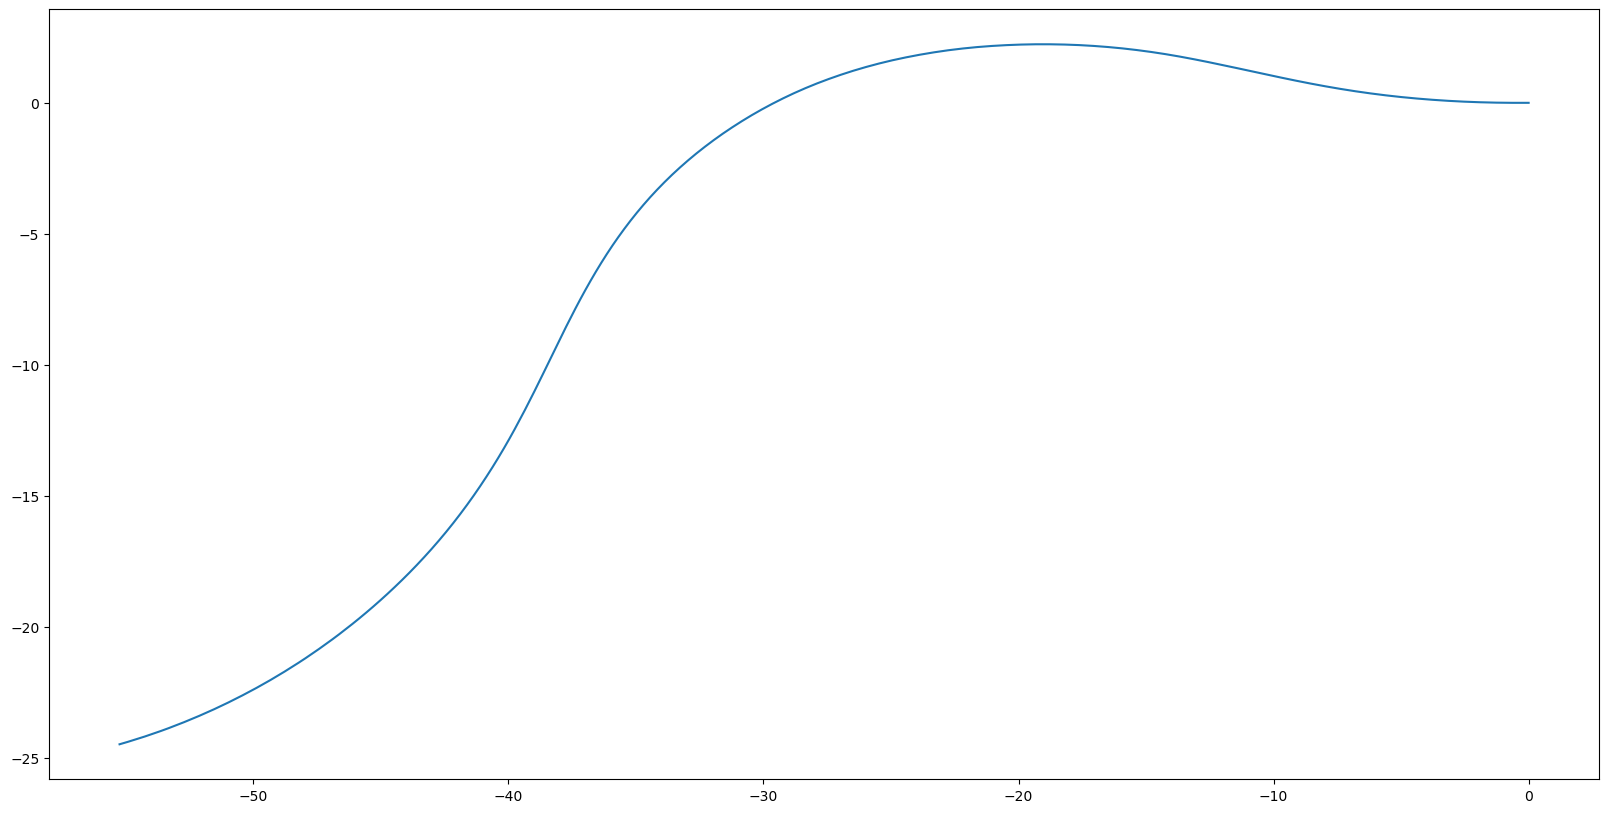

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(np.array(locations)[:, 0],np.array(locations)[:, 1]) 
# 可在rviz中簡單檢查是否與行車軌跡差不多
# 下圖中可看見最右邊是(0, 0)的位置，因為後最後一幀也會是最新一幀，它會是(0, 0) 